In [1]:
# install.packages('rpart')
library(moments)
library(dplyr, warn.conflicts = FALSE)
library(ggplot2)
library(repr)
library(reshape2)
library(caret)
library(rpart)
housing_data <- data.frame(read.table(file='../data/housing.data', header=FALSE, sep=""))
colnames(housing_data) <- c('CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV')
housing_data$MEDV <- NULL
housing_data$CHAS = factor(housing_data$CHAS)
housing_features = Filter(is.numeric, housing_data)

Loading required package: lattice


## Correlation Analysis

### Check for redundancy in the data

In [2]:
# functions from his holiness 
calculate_r_2 <- function(actual, prediction) {
    return (1 - (sum((actual-prediction)^2)/sum((actual-mean(actual))^2)))
}

calculate_r_2_for_feature <- function(data, feature) {
    n <- nrow(data)
    
    train_index <- sample(seq_len(n), size = 0.8*n)

    train <- data[train_index,]
    test <- data[-train_index,]
    
    this_formula = paste(feature,"~.")
    fit <- rpart(data=train, formula=as.formula(this_formula))

    y_test <- as.vector(test[[feature]])
    test[feature] <- NULL
    predictions <- predict(fit, test)
    return (calculate_r_2(y_test, predictions))
}

mean_r2_for_feature <- function (data, feature) {
    scores = c()
    for (i in 1:100) {
        scores = c(scores, calculate_r_2_for_feature(data, feature))
    }
    
    return (mean(scores))
}

In [3]:
for(feature in colnames(housing_features)) {
    print(paste(feature, ": ", mean_r2_for_feature(housing_features, feature)))
}

[1] "CRIM :  0.313769820899652"
[1] "ZN :  0.792481713571082"
[1] "INDUS :  0.869738084002867"
[1] "NOX :  0.837852446359394"
[1] "RM :  0.380384286843985"
[1] "AGE :  0.684413750924654"
[1] "DIS :  0.802330783404009"
[1] "RAD :  0.890896131765448"
[1] "TAX :  0.901264804982669"
[1] "PTRATIO :  0.806214809968809"
[1] "B :  0.114878131685526"
[1] "LSTAT :  0.534394996113608"


Many of the features can be predicted by the other features and are therefore redundant!!
ZN, INDUS, NOX, DIS, RAD, TAX, PTRATIO and only slightly redundant AGE.

### Check for correlation in the data

In [4]:
cormat = cor(housing_features)
cormat

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
CRIM,1.0000000,-0.2004692,0.4065834,0.4209717,-0.2192467,0.3527343,-0.3796701,0.6255051,0.5827643,0.2899456,-0.3850639,0.4556215
ZN,-0.2004692,1.0000000,-0.5338282,-0.5166037,0.3119906,-0.5695373,0.6644082,-0.3119478,-0.3145633,-0.3916785,0.1755203,-0.4129946
INDUS,0.4065834,-0.5338282,1.0000000,0.7636514,-0.3916759,0.6447785,-0.7080270,0.5951293,0.7207602,0.3832476,-0.3569765,0.6037997
NOX,0.4209717,-0.5166037,0.7636514,1.0000000,-0.3021882,0.7314701,-0.7692301,0.6114406,0.6680232,0.1889327,-0.3800506,0.5908789
RM,-0.2192467,0.3119906,-0.3916759,-0.3021882,1.0000000,-0.2402649,0.2052462,-0.2098467,-0.2920478,-0.3555015,0.1280686,-0.6138083
AGE,0.3527343,-0.5695373,0.6447785,0.7314701,-0.2402649,1.0000000,-0.7478805,0.4560225,0.5064556,0.2615150,-0.2735340,0.6023385
DIS,-0.3796701,0.6644082,-0.7080270,-0.7692301,0.2052462,-0.7478805,1.0000000,-0.4945879,-0.5344316,-0.2324705,0.2915117,-0.4969958
RAD,0.6255051,-0.3119478,0.5951293,0.6114406,-0.2098467,0.4560225,-0.4945879,1.0000000,0.9102282,0.4647412,-0.4444128,0.4886763
TAX,0.5827643,-0.3145633,0.7207602,0.6680232,-0.2920478,0.5064556,-0.5344316,0.9102282,1.0000000,0.4608530,-0.4418080,0.5439934
PTRATIO,0.2899456,-0.3916785,0.3832476,0.1889327,-0.3555015,0.2615150,-0.2324705,0.4647412,0.4608530,1.0000000,-0.1773833,0.3740443


### Prepare a heatmap of correlation and a pairplot of the data

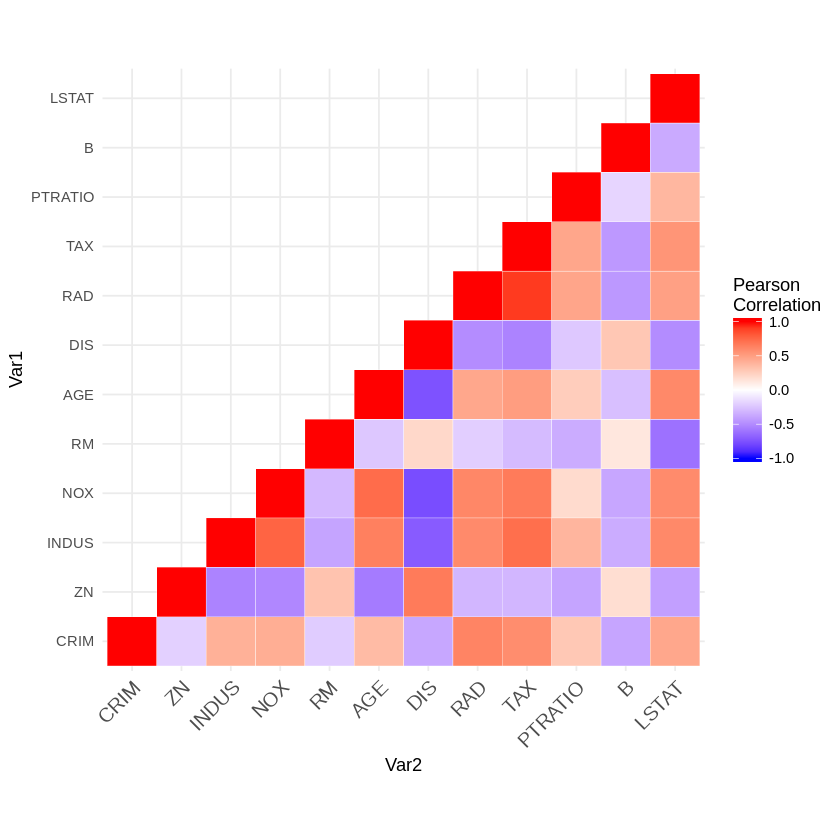

In [5]:
cormat[lower.tri(cormat)] <- NA
melted_cormat <- melt(cormat, na.rm = T)
ggplot(data = melted_cormat, aes(Var2, Var1, fill = value))+
 geom_tile(color = "white")+
 scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
   midpoint = 0, limit = c(-1,1), space = "Lab", 
   name="Pearson\nCorrelation") +
  theme_minimal()+ 
 theme(axis.text.x = element_text(angle = 45, vjust = 1, 
    size = 12, hjust = 1))+
 coord_fixed()

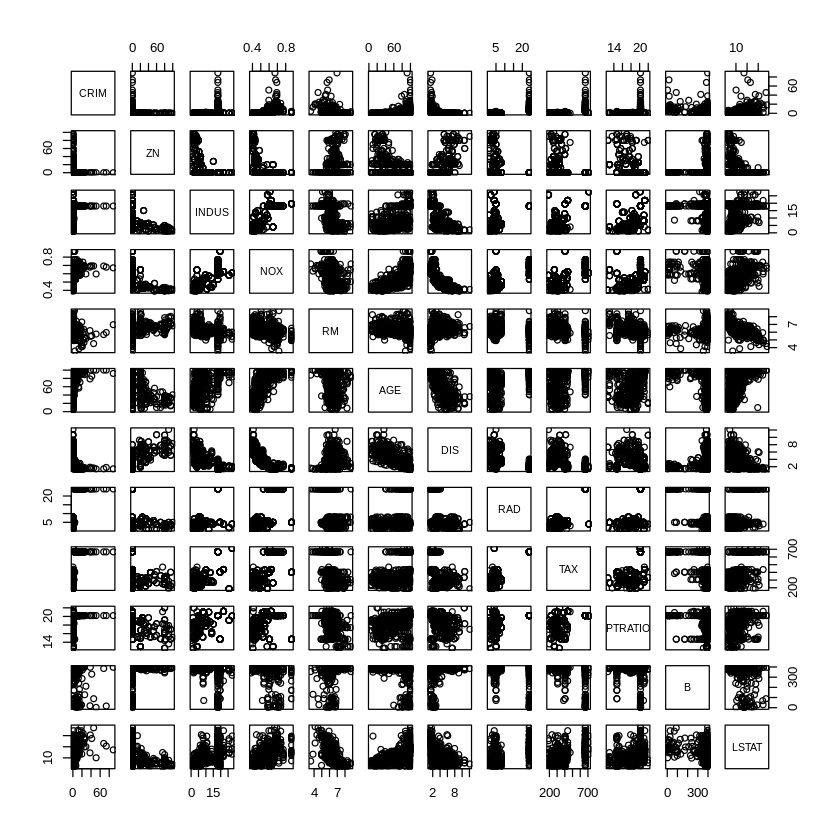

In [6]:
pairs(housing_features)

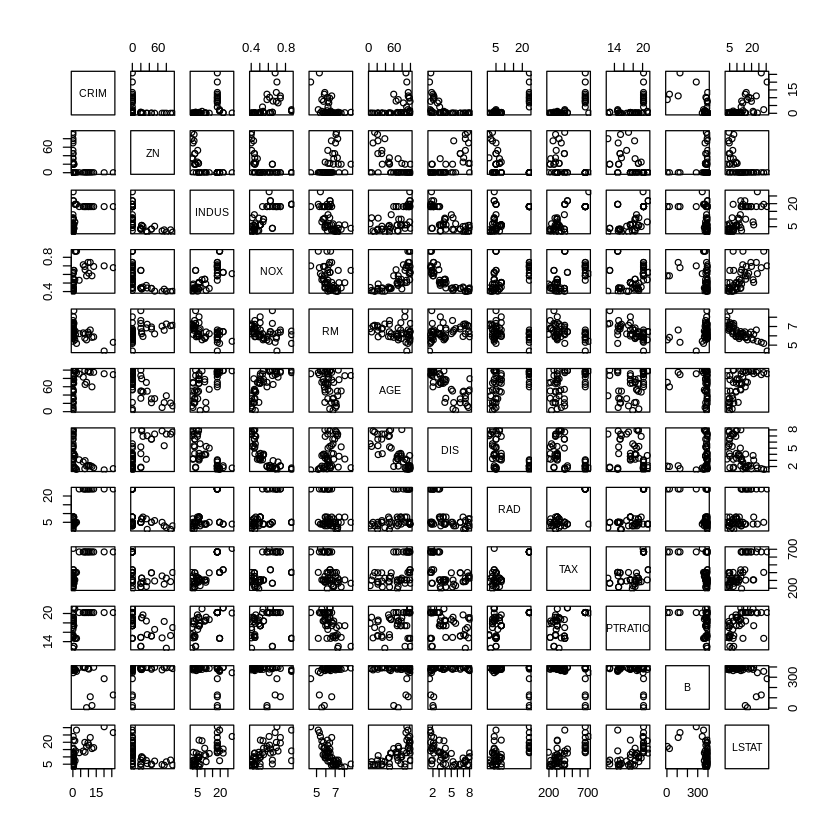

In [7]:
pairs(sample_n(housing_features, 50))

### Discuss how the correlation can be seen in the pairplot

If 2 variables are correlated, the scatter plots should look like a straight line with a slope of 1 or -1. A slope closer to 1 is positively correlated whereas closer to -1 is negatively correlated.
For example, DIS/NOX and DIS/AGE clearly have a negative correlation. Also, we can see a pretty strong postivie correlation in LSTAT/AGE and TAX/RAD.
The Pearson Correlation heatmap helps visualizes the correlation at a quick glance.